In [7]:
import warnings
warnings.filterwarnings('ignore')
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from data_loader import load_data
from data_preprocesser import preprocess_data
from realnvp import RealNVP 

Data successfully loaded...

Data successfully preprocessed...

TensorFlow version: 2.5.0
Number of dimensions: 37
Learning rate: 0.0001
Number of masked dimensions: 36

Successfully created model...

Optimizer and loss successfully defined...

Iteration 0: 60.43388366699219
Iteration 10000: 62.8946533203125
Iteration 20000: 51.936767578125
Iteration 30000: 48.95115280151367
Iteration 40000: 48.97389221191406
Iteration 50000: 48.37859344482422
Iteration 60000: 48.292030334472656
Iteration 70000: 59.42523956298828
Iteration 80000: 51.48047637939453
Iteration 90000: 51.44146728515625
Training finished...

Displaying results...


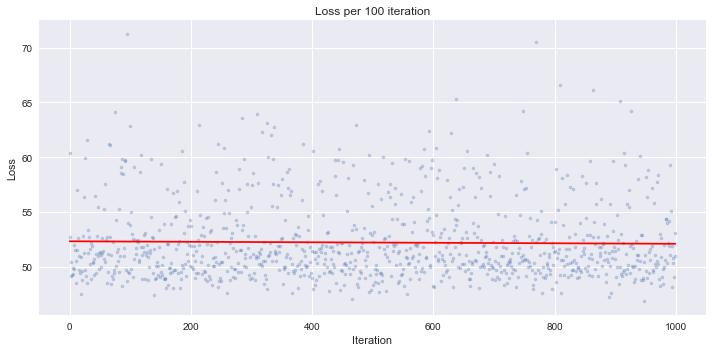

In [8]:
def train(session, loss, optimizer, steps=int(1e5)):
    
    """ optimize for all dimensions """
    
    recorded_steps = []
    recorded_losses = []
    for i in range(steps):
        _, loss_per_iteration = session.run([optimizer, loss])
        if i % 100 == 0:
            recorded_steps.append(i)
            recorded_losses.append(loss_per_iteration)
        if i % int(1e4) == 0:
            print('Iteration {iteration}: {loss}'.format(iteration=i,loss=loss_per_iteration))
    return recorded_losses

def plot_results(recorded_losses):
    
    """ plot loss """
    print('Displaying results...')
    fig = plt.figure(figsize=(10,5))
    x = np.arange(len(recorded_losses))
    y = recorded_losses
    m, b = np.polyfit(x, y, 1) 
    plt.scatter(x, y, s=10, alpha=0.3)
    plt.plot(x, m*x+b, c="r")
    plt.title('Loss per 100 iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

def main():
    
    """ load data """

    filename = 'prostate.xls'
    directory = '/Users/kaanguney.keklikci/Data/'

    loader = load_data(filename, directory)
    loader.create_directory(directory)
    data = loader.read_data(directory, filename)
    print('Data successfully loaded...\n')
    
    """ preprocess data """

    fillna_vals = ['sz', 'sg', 'wt']
    dropna_vals = ['ekg', 'age']
    drop_vals = ['patno', 'sdate']

    preprocesser = preprocess_data(StandardScaler(), fillna_vals, dropna_vals, drop_vals)
    data = preprocesser.dropna_features(data)
    data = preprocesser.impute(data)
    data = preprocesser.drop_features(data)
    data = preprocesser.encode_categorical(data)
    data = preprocesser.scale(data)
    print('Data successfully preprocessed...\n')
    
    """ set MAF parameters """

    batch_size = 32
    dtype = np.float32
    tf_version = tf.__version__
    params = 2
    hidden_units = [512,512]
    base_dist = tfp.distributions.Normal(loc=0., scale=1.)
    dims = data.shape[1]
    learning_rate = 1e-4
    
    """ initialize samples """

    realnvp = RealNVP(dtype, tf_version, batch_size, params, hidden_units, 
                      base_dist, dims, shift_only=True, 
                      is_constant_jacobian=True, masked_dimension_count=dims-1)

    dims = realnvp.get_dims(data)
    samples = realnvp.create_tensor(data)
    print(f'TensorFlow version: {realnvp.tf_version}')
    print(f'Number of dimensions: {realnvp.dims}')
    print(f'Learning rate: {learning_rate}')
    print(f'Number of masked dimensions: {realnvp.masked_dimension_count}\n')
    
    """ initialize RealNVP """

    realnvp = realnvp.make_realnvp(data)
    print('Successfully created model...\n')
    
    """ initialize loss and optimizer """

    loss = -tf.reduce_mean(realnvp.log_prob(samples))
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)

    session = tf.compat.v1.Session()
    tf.compat.v1.set_random_seed(42)
    session.run(tf.compat.v1.global_variables_initializer())
    print('Optimizer and loss successfully defined...\n')
    
    """ start training """
    recorded_losses = train(session, loss, optimizer)
    print('Training finished...\n')
    
    """ display results """
    plot_results(recorded_losses)
    
    
if __name__ == "__main__":
    main()